In [1]:
import uproot4
import numpy as np
import pandas as pd
import numba
import seaborn as sns
import awkward as ak
from scipy.stats import norm
from scipy.optimize import curve_fit
from coffea import hist
from coffea.processor import defaultdict_accumulator
import os
import copy

import tensorflow.keras as keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential, load_model

import optparse
import importlib
import pathlib

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
plt.style.use(hep.style.ROOT)

#Just to efficiently save plots
plot_dir = "plot/"
from datetime import datetime
now = datetime.now()
dt_string = now.strftime("%d-%m-%Y")
save_path = plot_dir + dt_string

print("Saving plots to: ", save_path)

#Plot settings
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'small',
         'axes.labelsize': 'large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

#line thickness
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 5

## Data processing codes
def getData(fname="", treeName="Events"):
    dq_dict_ak1 = uproot4.lazy(fname+":"+treeName)
    dq_events = ak.zip({
                        "nTrack": ak.zip({
                                "n_tracks": dq_dict_ak1['n_tracks']
                        }),
                        "GenVertex": ak.zip({
                                            "x": dq_dict_ak1["gvx"],
                                            "y": dq_dict_ak1["gvy"],
                                            "z": dq_dict_ak1["gvz"],
                                            "px": dq_dict_ak1["gpx"],
                                            "py": dq_dict_ak1["gpy"],
                                            "pz": dq_dict_ak1["gpz"]

                        }),
                        "GenP_St1": ak.zip({
                                            "px": dq_dict_ak1["gpx_st1"],
                                            "py": dq_dict_ak1["gpy_st1"],
                                            "pz": dq_dict_ak1["gpz_st1"],
                                            "x": dq_dict_ak1["gx_st1"],
                                            "y": dq_dict_ak1["gy_st1"],
                                            "z": dq_dict_ak1["gz_st1"],
                        }),
                        "Track_St1": ak.zip({
                                            "px": dq_dict_ak1["track_px_st1"],
                                            "py": dq_dict_ak1["track_py_st1"],
                                            "pz": dq_dict_ak1["track_pz_st1"],
                                            "x": dq_dict_ak1["track_x_st1"],
                                            "y": dq_dict_ak1["track_y_st1"],
                                            "z": dq_dict_ak1["track_z_st1"],
                        }),
                        "truth_dimuon":ak.zip({
                                            "mass": dq_dict_ak1['truthdimuon_mass'],
                                            "x": dq_dict_ak1['truthdimuon_x_vtx'],
                                            "y": dq_dict_ak1['truthdimuon_y_vtx'],
                                            "z": dq_dict_ak1['truthdimuon_z_vtx'],
                                            "px": dq_dict_ak1['truthdimuon_px'],
                                            "py": dq_dict_ak1['truthdimuon_py'],
                                            "pz": dq_dict_ak1['truthdimuon_pz'],
                            
                        }),
                       }, depth_limit=1)
    return dq_events

######## READ EVENTS
scan_dir = "/data/t3home000/dhoang/DQ/outfiles/DY_Jun1621_100k.root"

Saving plots to:  plot/07-07-2021


## 1. Produce the data set

In [3]:
def produce_data(infiles):
    
    dq_events = getData(infiles)
    
    #Only select tracks that are reconstructed
    selection = (ak.count(dq_events["Track_St1"].x, axis = 1) == 2)
    
    #Features
    x = np.asarray(dq_events["Track_St1"][selection].x)
    y = np.asarray(dq_events["Track_St1"][selection].y)
    z = np.asarray(dq_events["Track_St1"][selection].z)
    px = np.asarray(dq_events["Track_St1"][selection].px)
    py = np.asarray(dq_events["Track_St1"][selection].py)
    pz = np.asarray(dq_events["Track_St1"][selection].pz)
    
    X = np.dstack((x,y,z,px,py,pz))
    
    #Target
    vtx_x = np.asarray(ak.firsts(dq_events["GenVertex"][selection].x))
    vtx_y = np.asarray(ak.firsts(dq_events["GenVertex"][selection].y))
    vtx_z = np.asarray(ak.firsts(dq_events["GenVertex"][selection].z))
    vtx_px = np.asarray(ak.firsts(dq_events["GenVertex"][selection].px))
    vtx_py = np.asarray(ak.firsts(dq_events["GenVertex"][selection].py))
    vtx_pz = np.asarray(ak.firsts(dq_events["GenVertex"][selection].pz))
    vtx_m = np.asarray(ak.firsts(dq_events["truth_dimuon"][selection].mass))
    
    y = np.squeeze(np.dstack((vtx_x,vtx_y,vtx_z,vtx_m)))
    
    print("X's shape: ", X.shape)
    print("y's shape: ", y.shape)
    
    #Save the created data sets
    np.save("ML_dataset/X_track_reco_DY.npy", X)
    np.save("ML_dataset/y_track_reco_DY.npy", y)

#produce_data(scan_dir)

X's shape:  (5805, 2, 6)
y's shape:  (5805, 4)


## 2. Experiment with some models

In [2]:
def swap_axes(array):
    return np.transpose(array, (0,2,1))
def divide_z(array):
    return np.divide(array, [1,1,20])

#Load the data and divide it
def load_and_divide():
    
    X = np.load("ML_dataset/X_track_reco_DY.npy")
    y = np.load("ML_dataset/y_track_reco_DY.npy")
    
    print("X's shape: ", X.shape)
    print("y's shape: ", y.shape)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
    
    return swap_axes(X_train), y_train, swap_axes(X_test), y_test #Only reconstruct the spatial coordinate


X_train, y_train, X_test, y_test = load_and_divide()

X's shape:  (5805, 2, 6)
y's shape:  (5805, 4)


In [3]:
SIGMA_X = float(np.std(y_train[:,0]))
SIGMA_Y = float(np.std(y_train[:,1]))
SIGMA_Z = float(np.std(y_train[:,2]))

SIGMA_ARR = np.asarray([SIGMA_X**2, SIGMA_Y**2, SIGMA_Z**2])

## define loss function
import tensorflow.keras.backend as K
from tensorflow.python.ops import math_ops

def res_loss(ytrue, ypred):
    return math_ops.squared_difference(ypred, ytrue) / SIGMA_ARR

In [4]:
#Define the model
model = Sequential()

#Encoder
model.add(Conv1D(filters=30, kernel_size=2, strides=1, activation='LeakyReLU',input_shape=(X_train.shape[1:])))
model.add(Conv1D(filters=15, kernel_size=1, activation='LeakyReLU'))

model.add(Flatten())

#Latent space
model.add(Dense(50, activation = 'LeakyReLU'))

#Decoder
model.add(Dense(20, activation = 'LeakyReLU'))
model.add(Dense(10, activation = 'LeakyReLU'))
model.add(Dense(4))


model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 5, 30)             150       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 5, 15)             465       
_________________________________________________________________
flatten (Flatten)            (None, 75)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                3800      
_________________________________________________________________
dense_1 (Dense)              (None, 20)                1020      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 4

In [5]:
#Train the network
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=5)

history = model.fit(X_train, y_train,
                    epochs=1000,
                    batch_size=128,
                    verbose=2,
                    validation_split=0.20,
                    callbacks=[callback])

Epoch 1/1000
25/25 - 1s - loss: 14194.8662 - val_loss: 2516.1746
Epoch 2/1000
25/25 - 0s - loss: 738.9818 - val_loss: 55.6946
Epoch 3/1000
25/25 - 0s - loss: 50.0173 - val_loss: 18.2269
Epoch 4/1000
25/25 - 0s - loss: 11.8874 - val_loss: 7.4062
Epoch 5/1000
25/25 - 0s - loss: 5.9153 - val_loss: 5.2809
Epoch 6/1000
25/25 - 0s - loss: 4.8609 - val_loss: 4.5266
Epoch 7/1000
25/25 - 0s - loss: 4.1529 - val_loss: 3.8967
Epoch 8/1000
25/25 - 0s - loss: 3.5610 - val_loss: 3.3253
Epoch 9/1000
25/25 - 0s - loss: 3.0360 - val_loss: 2.8255
Epoch 10/1000
25/25 - 0s - loss: 2.5713 - val_loss: 2.3755
Epoch 11/1000
25/25 - 0s - loss: 2.1621 - val_loss: 1.9904
Epoch 12/1000
25/25 - 0s - loss: 1.8128 - val_loss: 1.6639
Epoch 13/1000
25/25 - 0s - loss: 1.5217 - val_loss: 1.4017
Epoch 14/1000
25/25 - 0s - loss: 1.2844 - val_loss: 1.1905
Epoch 15/1000
25/25 - 0s - loss: 1.0990 - val_loss: 1.0172
Epoch 16/1000
25/25 - 0s - loss: 0.9476 - val_loss: 0.8821
Epoch 17/1000
25/25 - 0s - loss: 0.8266 - val_loss: 

Epoch 140/1000
25/25 - 0s - loss: 0.0896 - val_loss: 0.0847
Epoch 141/1000
25/25 - 0s - loss: 0.0860 - val_loss: 0.0875
Epoch 142/1000
25/25 - 0s - loss: 0.0873 - val_loss: 0.0861
Epoch 143/1000
25/25 - 0s - loss: 0.0864 - val_loss: 0.0833
Epoch 144/1000
25/25 - 0s - loss: 0.0874 - val_loss: 0.0809
Epoch 145/1000
25/25 - 0s - loss: 0.0828 - val_loss: 0.0810
Epoch 146/1000
25/25 - 0s - loss: 0.0824 - val_loss: 0.0795
Epoch 147/1000
25/25 - 0s - loss: 0.0816 - val_loss: 0.0777
Epoch 148/1000
25/25 - 0s - loss: 0.0814 - val_loss: 0.0780
Epoch 149/1000
25/25 - 0s - loss: 0.0818 - val_loss: 0.0821
Epoch 150/1000
25/25 - 0s - loss: 0.0839 - val_loss: 0.0766
Epoch 151/1000
25/25 - 0s - loss: 0.0812 - val_loss: 0.0802
Epoch 152/1000
25/25 - 0s - loss: 0.0802 - val_loss: 0.0750
Epoch 153/1000
25/25 - 0s - loss: 0.0782 - val_loss: 0.0781
Epoch 154/1000
25/25 - 0s - loss: 0.0819 - val_loss: 0.0774
Epoch 155/1000
25/25 - 0s - loss: 0.0765 - val_loss: 0.0735
Epoch 156/1000
25/25 - 0s - loss: 0.0775

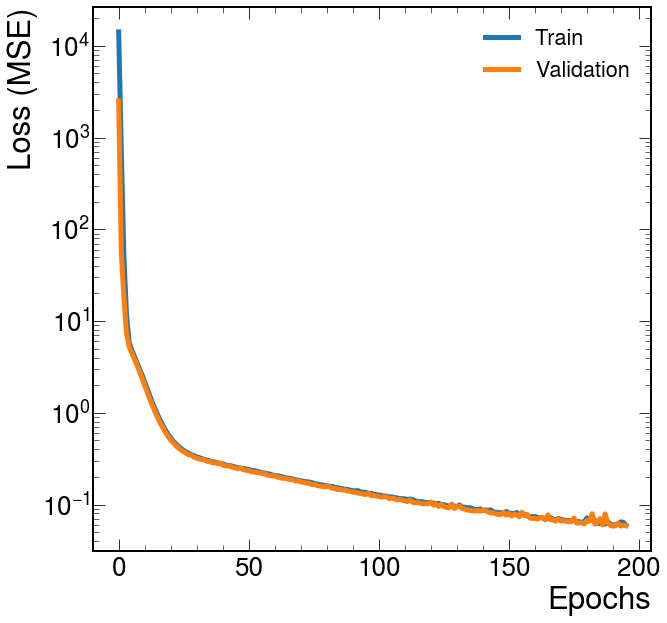

In [6]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.ylabel('Loss (MSE)')
plt.xlabel('Epochs')

plt.legend(['Train', 'Validation'], loc='upper right')
plt.yscale('log')
plt.show()

In [9]:
def gaussian_fit(residual,
                 #mean,
                 plot_bins = 100,
                 plot_range = (-0.5,0.5),
                 p_guess=[0.1, 0, 10],
                 residual_label = r'Reco $m_{dimuon}$ - Truth $m_{dimuon}$ [GeV]'):
    
    #Plot and fit
    plt.hist(residual,
         bins = plot_bins,
         range = plot_range,
         density = True)
    
    ## Gaussian fit
    ## Fit directly on the histogram
    def fit_function(x, A, mu, sig):
        return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

    bins = np.linspace(plot_range[0], plot_range[1], plot_bins+1)
    binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
    
    data_entries, _ = np.histogram(residual, bins=bins,
                                   range = plot_range,
                                   density = True)
    
    mask = data_entries!=0
    #Fit the function to the histogram data.
    popt, pcov = curve_fit(fit_function,
                           xdata=binscenters[mask],
                           ydata=data_entries[mask],
                           sigma = np.sqrt(data_entries[mask]),
                           absolute_sigma = False,
                           p0=p_guess)
    
    #Error for parameter estimations
    perr = np.sqrt(np.diag(pcov))
    print("Error for parameter esimations: ", perr)

    std_fit = np.abs(popt[2])
    mean_fit = popt[1]
    
    print("Standard deviation (fit) is", std_fit)
    print("Mean (fit) is", mean_fit)
    
    #Plot fitted gaussian
    plt.plot(bins,
             fit_function(bins, *popt),
             "r-",
             linewidth=4,
             label='Best fit')

    plt.plot([],[], 'none', label=r'$\mu=%.2f$ [cm]'%popt[1])
    plt.plot([],[], 'none', label=r'$\sigma=%.4f$ [cm]'%abs(popt[2]))
    #plt.plot([],[], 'none', label=r'$<m>=%.2f$ [GeV]'%mean)
    #plt.plot([],[], 'none', label=r'$\sigma/<m>=%.4f$ [%%]'%(abs(popt[2])/mean))
    
    #Label the axes
    plt.xlabel(residual_label)
    plt.ylabel('Normalized counts')

    plt.legend()

    plt.show()

def plot_resolution(y_pred, y_test, index = 0):

    if index == 0:
        residual_range = (-2.5,2.5)
        x_label = r"$X_{reco}$ - $X_{truth}$ [cm]"
    elif index == 1:
        residual_range = (-2.5,2.5)
        x_label = r"$Y_{reco}$ - $Y_{truth}$ [cm]"
    elif index == 2:
        residual_range = (-5,5)
        x_label = r"$Z_{reco}$ - $Z_{truth}$ [cm]"
    elif index == 3:
        residual_range = (-2.5,2.5)
        x_label = r"$m_{reco}$ - $m_{truth}$ [cm]"
        
    residual = y_pred[:, index] - y_test[:, index]
    #residual = y_pred - y_test
    
    gaussian_fit(residual, plot_range = residual_range, residual_label = x_label)

In [8]:
y_pred = model.predict(X_test)

Error for parameter esimations:  [0.04914649 0.01236819 0.00989935]
Standard deviation (fit) is 0.34314644451082293
Mean (fit) is 0.09015420886159767


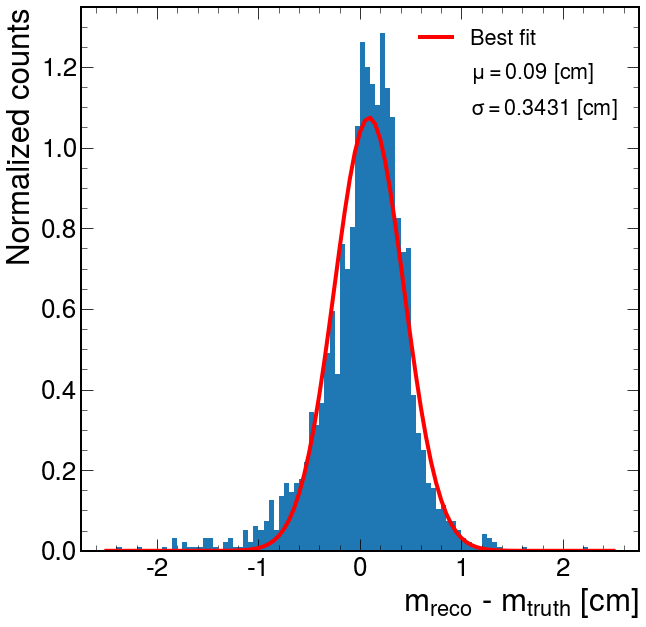

In [13]:
plot_resolution(y_pred, y_test, index = 3)